### 1. 介绍 Introduction
-------------

2015年ImageNet赛冠军模型

引入了残差块（residual blocks）。

其问题来源是当时随着深度神经网络的不断加深，发现当层数超过二十几层时，继续加深网络，训练精度和测试精度都会快速下降。

残差的块的特点是，理论上可以让网络可以选择性的不学习某些层，而不是如以前网络一样必须学习。即$F(x)=0$

论文地址：[ResNet论文](https://arxiv.org/pdf/1512.03385)

In [24]:
from IPython.display import Image, display
url = 'https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png'
display(Image(url=url, width=400))

In [25]:
url = 'https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png'
display(Image(url=url, width=600))

## 2. torchvision中的ResNet18
---

- ResNet18网络由一系列共8个的BasicBlock组成，也就是残差块。
- 每个残差块中有2次卷次，2次Batch Normalization, 2次ReLU激活
- 每两个残差块组成一个层，共4个层，每个层中有4层卷积，共16层。加上开始的conv1, 以及最后的FC层，共18层。
- 除layer1外，后面三层的第一个块都进行了下采样。高宽减半，通道数翻倍。
- torchvision中除了resnet18外，还有resnet34, resnet50, resnet101, resnet152。并且都提供了预训练模型，可以载入权重，再进行fine tuning。

In [26]:
import torchvision.models as models
from torchinfo import summary

ResNet18 = models.resnet18()
summary(ResNet18, (1, 3, 96, 96)) #用torchinfo中的summary方法对模型尺寸和结构进行输出

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 48, 48]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 48, 48]           128
├─ReLU: 1-3                              [1, 64, 48, 48]           --
├─MaxPool2d: 1-4                         [1, 64, 24, 24]           --
├─Sequential: 1-5                        [1, 64, 24, 24]           --
│    └─BasicBlock: 2-1                   [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                  [1, 64, 24, 24]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 24, 24]           128
│    │    └─ReLU: 3-3                    [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-4                  [1, 64, 24, 24]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 24, 24]           128
│    │    └─ReLU: 3-6                    [1, 64, 24, 24]           --
│

In [27]:
print(ResNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. 修改实现
---

### 3.1 导入必要的包

In [28]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets
from torch.amp import autocast, GradScaler

### 3.2 设定超参数

In [29]:
batch_size = 128 # 批次大小
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 使用GPU
num_classes = 10 # 类别数
lr = 1e-3 #学习率
epochs = 20 # 训练轮次
accumulation_steps = 4  # 设置梯度累积的步数

### 3.3 读入数据

In [30]:
# 定义数据转换方法
transform = transforms.Compose([transforms.Resize((96, 96)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])
# 定义训练集
train_dataset = datasets.CIFAR10(root = './data',
                                          train = True,
                                          transform = transform,
                                          download = True)
# 定义测试集
test_dataset = datasets.CIFAR10(root = './data',
                                         train = False,
                                         transform = transform,
                                         download = True)

# 加载训练数据，并打乱
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# 加载测试数据
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


### 3.4 采用tensorboard对读入的数据进行查看

- 注：此处代码由大语言模型迭代生成，有修订

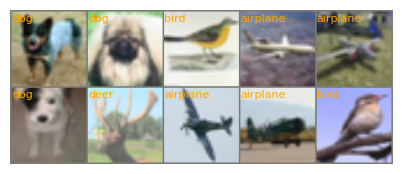

In [31]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# 定义反标准化函数
def imshow(img):
    # 反标准化
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    img = img * std + mean  # 反标准化
    # 限制像素值在 [0, 1] 范围
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    return npimg

# 显示指定数量的图片，并在每张图像上标注标签
def show_images_in_grid(images, labels, class_names, num_images=10, images_per_row=5):
    # 确保显示的图片数量是10
    images = images[:num_images]
    labels = labels[:num_images]
    # 使用 make_grid 来排列图像，分为两行，每行 5 张图像
    img_grid = torchvision.utils.make_grid(images, nrow=images_per_row)
    # 转换图像格式并显示
    npimg = imshow(img_grid)    
    # 使用 matplotlib 显示图像
    plt.figure(figsize=(5, 2))  # 设置图像大小
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 不显示坐标轴

    # 在每张图像上显示标签
    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        plt.text(col * 98 + 2, row * 98 + 15,  # x, y 坐标（调整偏移量）
                 class_names[labels[i]],  # 显示标签
                 color='orange', fontsize=8, ha='left')
    plt.show()

# CIFAR-10 类别名称（标签对应的类名）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 创建一个 SummaryWriter 实例
writer = SummaryWriter('runs/cifar10_samples')
# 获取一个批次的样本
dataiter = iter(train_loader)
images, labels = next(dataiter)
# 显示 10 张图像（分成两行，每行5张）并显示标签
show_images_in_grid(images, labels, class_names)
# 将图像添加到 TensorBoard
writer.add_image('CIFAR10_images', torchvision.utils.make_grid(images))
# 关闭 writer
writer.close()

### 3.5 构造ResNet18

- 定义构造ResidualBlock的类或函数，主要参数是输入和输出通道数
- 再逐步实现整个网络

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Parameters / 参数说明:
        in_channels (int): The number of input channels / 输入通道数
        out_channels (int): The number of output channels / 输出通道数
        stride (int): The stride of the convolution (default 1) / 卷积步长（默认为1）
        """
        super(ResidualBlock, self).__init__()

        # Main path (convolutional layers) / 主路径（卷积层）
        self.main = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),  # inplace=True to save memory / inplace=True 节省内存
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels))

        # Shortcut path (1x1 convolution for dimensionality match) / 捷径路径（1x1卷积调整维度）
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

        # ReLU activation function / ReLU激活函数
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass / 前向传播
        """
        # Forward pass through the main path / 主路径的前向传播
        out = self.main(x)
        
        # Forward pass through the shortcut path / 捷径路径的前向传播
        shortcut = self.shortcut(x)
        
        # Add the shortcut to the output and apply ReLU / 将捷径路径与主路径输出相加并应用ReLU激活
        out += shortcut
        out = self.relu(out)
        
        return out

In [38]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ResNet18, self).__init__()
        
        # 初始卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # 定义四个残差阶段
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)   # Stage 1
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)  # Stage 2
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2) # Stage 3
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2) # Stage 4
        
        # 分类头
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 自动适应不同尺寸的输入
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        
        # 第一个残差块可能需要下采样
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        
        # 后续残差块保持通道数和尺寸
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        x = self.avgpool(x) 
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [36]:
# 打印即将要训练的模型
model = ResNet18()
summary(model, (1, 3, 96, 96)) #用torchinfo中的summary方法对模型尺寸和结构进行输出

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 24, 24]           --
│    └─Conv2d: 2-1                       [1, 64, 48, 48]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 48, 48]           128
│    └─ReLU: 2-3                         [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-4                    [1, 64, 24, 24]           --
├─Sequential: 1-2                        [1, 64, 24, 24]           --
│    └─ResidualBlock: 2-5                [1, 64, 24, 24]           --
│    │    └─Sequential: 3-1              [1, 64, 24, 24]           73,984
│    │    └─Sequential: 3-2              [1, 64, 24, 24]           --
│    │    └─ReLU: 3-3                    [1, 64, 24, 24]           --
│    └─ResidualBlock: 2-6                [1, 64, 24, 24]           --
│    │    └─Sequential: 3-4              [1, 64, 24, 24]           73,984
│  

### 3.6 确定损失函数和优化器

In [39]:
model = model.to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)
scaler = GradScaler(device)  # 用于缩放梯度

### 3.7 训练函数

- 采用的半精度训练方式
- 手动释放显存

In [40]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    optimizer.zero_grad() # 梯度清理
    # 遍历训练数据
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device) # 将数据和标签挪到GPU        

        # 使用autocast进行半精度计算
        with autocast(device_type='cuda'):
            output = model(data) # 前向传播
            loss = criterion(output, label) # 原始总损失
            scaled_loss = loss/accumulation_steps # 缩放损失用于梯度累积

        # 使用GradScaler进行反向传播和参数更新
        scaler.scale(scaled_loss).backward() # 缩放损失并进行反向传播
        # 根据累积次数更新参数
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer) # 使用缩放后的梯度进行参数更新
            scaler.update() # 更新缩放因子
            optimizer.zero_grad(set_to_none=True)  # 清空梯度
        
        train_loss += loss.item()  #计算损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += data.size(0) # 总预测数量

        #手动释放显存
        del data, label, output, loss
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_loader.dataset) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

### 3.8 验证函数

- 也采用的半精度的方式，但也可以不用

In [41]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for data, label in test_loader: 
            data, label = data.to(device), label.to(device) #数据迁移到GPU            
            output = model(data) # 前向传播

            # 使用autocast进行半精度计算
            with autocast(device_type='cuda'):
                output = model(data) # 前向传播           
                loss = criterion(output, label) # 计算当前批次损失
            
            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1) # 取得每行最大值的索引，获取预测结果。
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += data.size(0) # 总预测数量
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

### 3.9 训练

In [42]:
for epoch in range(1, epochs+1):
    train(epoch)
    evaluate(epoch)
    torch.cuda.empty_cache()

Epoch:1	Training Loss:1.502625, Accuracy:0.462740
Epoch:1	Validation Loss:1.190942, Accuracy:0.576300
Epoch:2	Training Loss:0.951847, Accuracy:0.662340
Epoch:2	Validation Loss:0.863960, Accuracy:0.697600
Epoch:3	Training Loss:0.732056, Accuracy:0.740900
Epoch:3	Validation Loss:0.849548, Accuracy:0.706100
Epoch:4	Training Loss:0.580866, Accuracy:0.795380
Epoch:4	Validation Loss:0.635795, Accuracy:0.776200
Epoch:5	Training Loss:0.466890, Accuracy:0.835840
Epoch:5	Validation Loss:0.614763, Accuracy:0.790500
Epoch:6	Training Loss:0.362786, Accuracy:0.873960
Epoch:6	Validation Loss:0.628276, Accuracy:0.788900
Epoch:7	Training Loss:0.287118, Accuracy:0.899260
Epoch:7	Validation Loss:0.609129, Accuracy:0.811900
Epoch:8	Training Loss:0.206496, Accuracy:0.928680
Epoch:8	Validation Loss:0.688589, Accuracy:0.796900
Epoch:9	Training Loss:0.154332, Accuracy:0.945160
Epoch:9	Validation Loss:0.714586, Accuracy:0.801300
Epoch:10	Training Loss:0.113847, Accuracy:0.960140
Epoch:10	Validation Loss:0.7182

## 4. 可视化CNN卷积核

In [47]:
print(model)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [50]:
model.conv1[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

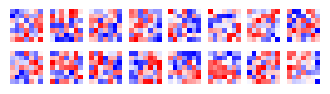

In [51]:
# 获取指定卷积层的权重
conv1_weights = model.conv1[0].weight.data.cpu().numpy()[:16]  # 获取第一层卷积核，提取前16个核
num_kernels = conv1_weights.shape[0]  # 这里是 16
fig, axes = plt.subplots(2, 8, figsize=(4, 1))  # 2x8 网格
for i in range(num_kernels):
    ax = axes[i // 8, i % 8]
    ax.imshow(conv1_weights[i, 0, :, :], cmap='bwr')  # 选择第一个通道来显示
    ax.axis('off')
plt.show()

## 5. 可视化CNN特征图

### 5.1 从数据集中存几张图片

10张测试样本已保存到: d:\Github\Deep-Learning\cifar10_test_samples


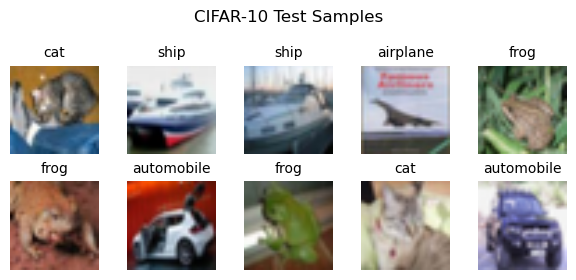

In [52]:
from PIL import Image

# 创建保存目录
save_dir = "./cifar10_test_samples"
os.makedirs(save_dir, exist_ok=True)

# CIFAR-10 类别名称（标签对应的类名）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 创建画布
plt.figure(figsize=(6, 2.5))

# 保存前10张图片
for idx in range(10):
    image, label = test_dataset[idx]
    # 反归一化处理（关键步骤）
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    image = image * std + mean  # 反标准化
    image = torch.clamp(image, 0, 1)  # 裁剪到[0,1]范围
    
    # 转换tensor到PIL图像
    pil_image = transforms.ToPILImage()(image)

    # 排版
    plt.subplot(2, 5, idx+1)
    plt.imshow(pil_image)
    plt.title(f'{class_names[label]}', fontsize=10)
    plt.axis('off')
    
    # 生成文件名
    filename = f'{idx}_{class_names[label]}.png'
    save_path = os.path.join(save_dir, filename)
    
    # 保存图片
    pil_image.save(save_path)
print("10张测试样本已保存到:", os.path.abspath(save_dir))

# 调整布局并显示
plt.tight_layout()
plt.suptitle('CIFAR-10 Test Samples', y=1.1, fontsize=12)
plt.show()

### 5.2 读取一张图片

In [53]:
# 读取一张图像，转化为训练时候的数据格式
img = plt.imread('./cifar10_test_samples/4_frog.png')
transform_img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])
img = transform_img(img)
img = img.unsqueeze(0)
print(img.size())

torch.Size([1, 3, 96, 96])


### 5.3 hook特征图

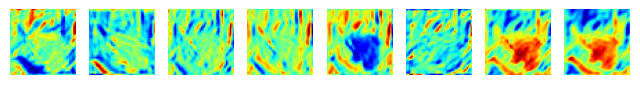

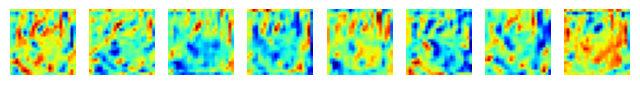

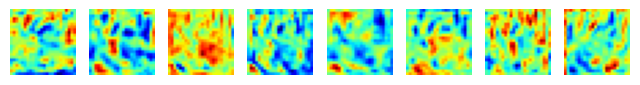

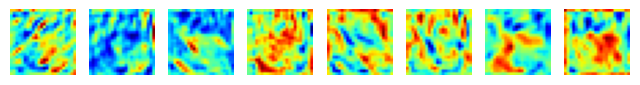

In [54]:
# 定义 Hook 类来捕捉每个卷积层的输出
class Hook(object):
    def __init__(self):
        self.features = []

    def __call__(self, module, fea_in, fea_out):
        # 捕捉卷积层的输出
        self.features.append(fea_out)
        return None

# 提取并可视化卷积层的特征图
def extract_and_visualize_features(model, img):
    # 确保模型在 GPU 上，并将输入数据也转移到相同设备
    device = next(model.parameters()).device  # 获取模型的设备（GPU/CPU）
    img = img.to(device)  # 将输入图像移动到相同的设备

    # 初始化 Hook 对象
    hook = Hook()

    # 遍历模型中的所有层，注册hook到每个卷积层
    handles = []
    conv_layers = 0  # 用来限制提取卷积层的数量
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):  # 判断是否是卷积层
            handle = layer.register_forward_hook(hook)
            handles.append(handle)
            conv_layers += 1
        if conv_layers >= 4:  # 只提取前4个卷积层的特征图
            break

    # 将模型设置为评估模式，并执行一次前向传播
    model.eval()
    with torch.no_grad():
        _ = model(img)

    # 可视化每个卷积层的特征图
    for layer_idx, feature in enumerate(hook.features):
        # 假设我们只看第一个样本（batch_size=1）
        feature_map = feature[0].cpu().detach()  # 获取第一个图像的特征图
        num_features = feature_map.shape[0]  # 特征图的数量（通道数）

        # 显示每个卷积层的特征图
        plt.figure(figsize=(8, 4))
        for i in range(min(8, num_features)):  # 最多显示每个卷积层的前8个特征图
            plt.subplot(1, 8, i+1)  # 4x2 grid，每个卷积层最多显示8个特征
            plt.imshow(feature_map[i], cmap='jet')
            plt.axis('off')
        plt.show()

    # 移除所有的hook
    for handle in handles:
        handle.remove()

model = model.to(device)  # 将模型移动到GPU
# 调用函数提取并可视化特征图
extract_and_visualize_features(model, img)

## 6. 保存模型

In [58]:
save_dir = './model_pkl/ResNet18.pth'
# 保存整个模型
# torch.save(model, save_dir) 
# 保存模型权重
torch.save(model.state_dict(), save_dir)

由于 Hook 类无法被序列化（pickling）。PyTorch 在保存模型时会将模型的所有组件（包括它们的状态和可能的钩子（hook））进行序列化，但某些对象，如定义的 Hook 类，不能被直接序列化。这是因为 Hook 类是动态创建的，并且它引用了某些在 \_\_main\_\_ 环境中定义的内容，导致它不能像普通类那样被 pickled。

In [59]:
# 重新定义模型结构（确保模型结构与保存时的结构一致）
# model = ResNet18()
# 加载模型权重
# model.load_state_dict(torch.load(save_dir))
# 将模型设置为评估模式
# model.eval()

## 7. 收获

ResNet的经验：
- 通过结构创新（残差学习），突破了之前模型的训练瓶颈，释放深度网络的潜力。
- 残差结构结合批量归一化（Batch Normalization），在增加深度的同时保持了泛化能力
- 解决率网络越深，训练和泛化性能下降的问题
- shotcut和BN的混合作用，缓解了梯度消失和梯度爆炸问题
- 应用上，ResNet系列（如ResNet-50、ResNet-101）现在依然是很多视觉任务的基准模型